#**HW4 : Recurrent Neural Networks**
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. As a dataset, we will use the IMDB dataset. It contains the text of some reviews and the sentiment given by the authors of the reviews (positive review or negative review). The input to the RNN is the sequence of words that compose a review. The learning task consists in predicting the sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will explore how to face overfitting by Dropout. 

##[TO COMPLETE] Exercise 4.1: Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(454545)

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [2]:
num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

Let's also get the word indexs (word to word-id)

In [3]:
word_index = keras.datasets.imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur.
*Please, notice that Keras does not use index 0, so we can shift the indices only by 3 positions.*

In [4]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [5]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [6]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [7]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

###[TO COMPLETE] Define the model:
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer is a Dense layer with a sigmoid activation function since this is a binary classification problem

In the following cell, we already inserted in the model the first Embedding layer. Add the recurrent layer (using 32 units), and the output layer. Select the right activation function for the output layer and motivate your choice. Finally, select the right loss function inserting the right value for the "loss" parameter in model.compile() and motivate your choice.
Please, insert your answers in a new text cell below this one, immediately before the code.

In [8]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(32))
model.add(keras.layers.Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

I used the binary crossentropy loss since it is suited use for binary classification proble with target values between 0 and 1, like this case.

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          100000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                1376      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


###Train the model:
Now we have to train the model

In [ ]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 27s 131ms/step - loss: 0.6654 - accuracy: 0.5718 - val_loss: 0.4529 - val_accuracy: 0.8080
Epoch 2/10
196/196 [==============================] - 24s 124ms/step - loss: 0.4004 - accuracy: 0.8309 - val_loss: 0.6256 - val_accuracy: 0.6876
Epoch 3/10
196/196 [==============================] - 24s 123ms/step - loss: 0.3575 - accuracy: 0.8526 - val_loss: 0.3807 - val_accuracy: 0.8428
Epoch 4/10
196/196 [==============================] - 24s 124ms/step - loss: 0.3024 - accuracy: 0.8838 - val_loss: 0.4086 - val_accuracy: 0.8361
Epoch 5/10
196/196 [==============================] - 24s 124ms/step - loss: 0.2984 - accuracy: 0.8732 - val_loss: 0.3794 - val_accuracy: 0.8482
Epoch 6/10
196/196 [==============================] - 24s 124ms/step - loss: 0.1964 - accuracy: 0.9278 - val_loss: 0.3730 - val_accuracy: 0.8509
Epoch 7/10
196/196 [==============================] - 24s 125ms/step - loss: 0.1531 - accuracy: 0.9460 - val_loss: 0.4177 - val_ac

Print the values of accuracy and the loss , and evaluate the model on the test set

In [9]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

#plot_loss(history)

#plot_accuracy(history)

#scores = model.evaluate(X_test_trim, y_test, verbose=2)
#print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

##[TO COMPLETE] Exercise 4.2: LSTM and GRU
In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer, respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use, respectively?

*insert cells (code and text) with results and discussion immediately after this cell*

In [ ]:
#LSTM
model_lstm = keras.models.Sequential()
model_lstm.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_lstm.add(keras.layers.LSTM(16))
model_lstm.add(keras.layers.Dense(units=1,activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

In [ ]:
model_lstm.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                1728      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 101,745
Trainable params: 101,745
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
196/196 [==============================] - 48s 236ms/step - loss: 0.6335 - accuracy: 0.6331 - val_loss: 0.3693 - val_accuracy: 0.8468
Epoch 2/10
196/196 [==============================] - 50s 255ms/step - loss: 0.3010 - accuracy: 0.8873 - val_loss: 0.2953 - val_accuracy: 0.8771
Epoch 3/10
196/196 [==============================] - 50s 254ms/step - loss: 0.2065 - accuracy: 0.9280 - val_loss: 0.3439 - val_accuracy: 0.8625
Epoch 4/10
196/196 [==============================] - 49s 251ms/step - loss: 0.1638 - accuracy: 0.9429 - val_loss: 0.3252 - val_accuracy: 0.8705
Epoch 5/10
196/196 [==============================] - 51s 260ms/step - loss: 0.1317 - accuracy: 0.9597 - val_loss: 0.3411 - val_accuracy: 0.8702
Epoch 6/10
196/196 [==============================] - 51s 262ms/step - loss: 0.1172 - accuracy: 0.9624 - val_loss: 0.3807 - val_accuracy: 0.8565
Epoch 7/10
196/196 [==============================] - 52s 267ms/step - loss: 0.0962 - accuracy: 0.9716 - val_loss: 0.4993 - val_ac

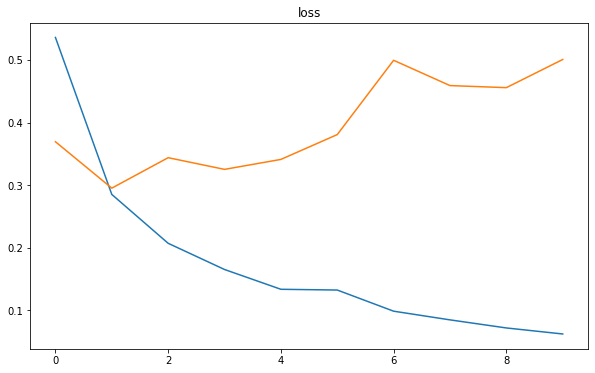

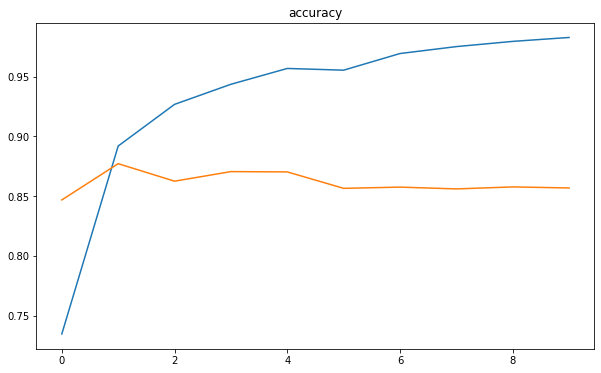

In [ ]:
history_lstm = model_lstm.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))
plot_loss(history_lstm)

plot_accuracy(history_lstm)

scores = model_lstm.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_lstm.metrics_names[1], scores[1]*100))

In [ ]:
#GRU
model_gru = keras.models.Sequential()
model_gru.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_gru.add(keras.layers.GRU(16))
model_gru.add(keras.layers.Dense(units=1,activation='sigmoid'))

model_gru.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

In [ ]:
model_gru.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                1344      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 101,361
Trainable params: 101,361
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
196/196 [==============================] - 46s 225ms/step - loss: 0.6536 - accuracy: 0.5939 - val_loss: 0.4497 - val_accuracy: 0.8005
Epoch 2/10
196/196 [==============================] - 47s 239ms/step - loss: 0.3319 - accuracy: 0.8621 - val_loss: 0.3362 - val_accuracy: 0.8603
Epoch 3/10
196/196 [==============================] - 47s 241ms/step - loss: 0.2263 - accuracy: 0.9147 - val_loss: 0.3287 - val_accuracy: 0.8673
Epoch 4/10
196/196 [==============================] - 47s 241ms/step - loss: 0.1784 - accuracy: 0.9382 - val_loss: 0.3589 - val_accuracy: 0.8621
Epoch 5/10
196/196 [==============================] - 47s 239ms/step - loss: 0.1493 - accuracy: 0.9509 - val_loss: 0.3740 - val_accuracy: 0.8558
Epoch 6/10
196/196 [==============================] - 47s 239ms/step - loss: 0.1386 - accuracy: 0.9565 - val_loss: 0.4353 - val_accuracy: 0.8587
Epoch 7/10
196/196 [==============================] - 46s 237ms/step - loss: 0.1209 - accuracy: 0.9614 - val_loss: 0.4272 - val_ac

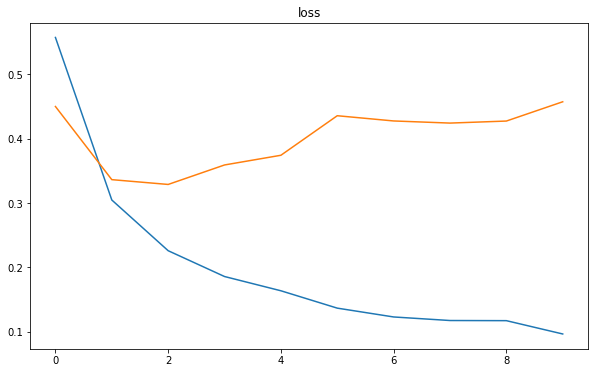

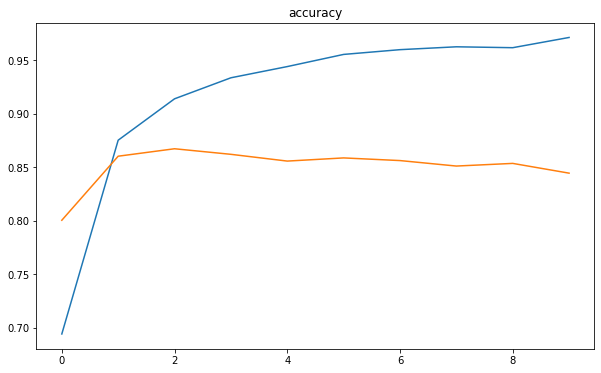

In [ ]:
history_gru = model_gru.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))
plot_loss(history_gru)
plot_accuracy(history_gru)

scores = model_gru.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_gru.metrics_names[1], scores[1]*100))

LSTM and GRU are more complex than the simple RNN since their units include a memory cell that can maintain information in memory for long periods of time, so as a consequence with the same number of units it tunes an higher number of parameters. For this reason, in order to have a similar number of parameters, I choose a smaller number of units in these two models layer (16) than the one first one (32).
Instead, mantaining the same number of units for all the models, it is possible to observe an evident difference between the first and the other two in terms of number of parameters and training time (both lower for the first) due to the less complexity just mentioned. Regarding the performance it is slightly improved both in LSTM and GRU (a better test evaluation score of almost 2-3%)

LSTM and GRU look very similar, their efficiency is comparable for this problem. Also the number of parameters and the training time are very close, the small difference (both are a bit smaller for GRU) is due to the fact that this last layer has fewer gates, so is less complex than the LSTM one.

Note that all 3 models show overfitting.

##Bidirectional LSTM
Let's modify the previous code by using a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [ ]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                11008     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 119s 586ms/step - loss: 0.6539 - accuracy: 0.5945 - val_loss: 0.4017 - val_accuracy: 0.8394
Epoch 2/5
196/196 [==============================] - 113s 576ms/step - loss: 0.3372 - accuracy: 0.8660 - val_loss: 0.3381 - val_accuracy: 0.8590
Epoch 3/5
196/196 [==============================] - 113s 579ms/step - loss: 0.2499 - ac

391/391 - 18s - loss: 0.3457 - accuracy: 0.8697
accuracy: 86.97%


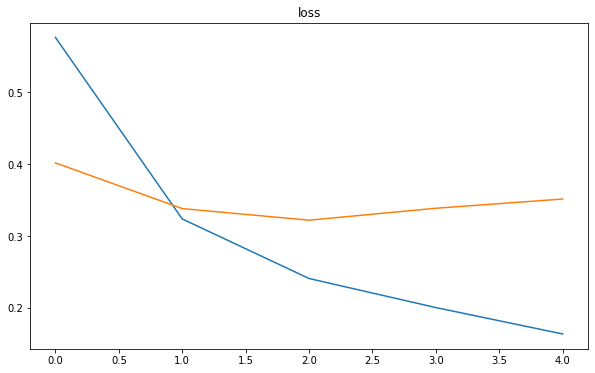

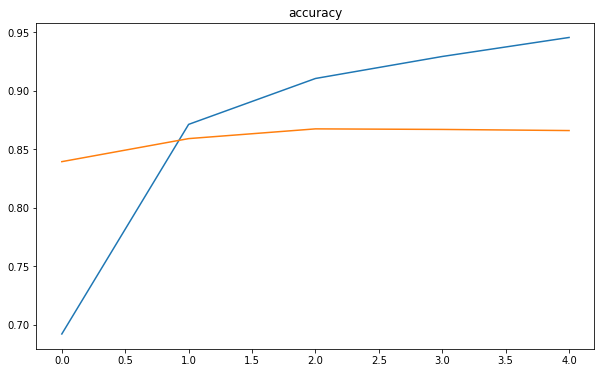

In [ ]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

##[TO COMPLETE] Exercise 4.3: Dropout
In the bi-directional model is it possible to notice that the model overfits the training data.
A possible solution to this problem could be applying the dropout technique to input or output layers.

In Keras, to apply dropout you have to add a [keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer.

**[TO COMPLETE]**: modify the code of the previous exercise adding the Dropout to the input and/or output layers. Find the Dropout probability that reduces the overfitting issue.

**[TO COMPLETE]** Is it possible to modify the values of some other hyper-parameters to mitigate overfitting? And if this is the case, explain why and perform an experimental study demonstrating your point.

*insert cells (code and text) with results and discussion immediately after this cell*

**Dropout**
The code below shows an implementation of the previous model using 3 new models with 3 different use of dropout tecnique: applied to input layer, to output layer and to both layers. The chosen dropout probability is set to 20%.

In [23]:
  model_bidirectional1 = keras.models.Sequential()
  model_bidirectional1.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
  model_bidirectional1.add(keras.layers.Dropout(0.3))
  model_bidirectional1.add(keras.layers.Bidirectional(keras.layers.LSTM(16)))
  model_bidirectional1.add(keras.layers.Dense(1, activation="sigmoid"))
  model_bidirectional1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

  model_bidirectional1.evaluate(X_test_trim, y_test, verbose=2)

  model_bidirectional2 = keras.models.Sequential()
  model_bidirectional2.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
  model_bidirectional2.add(keras.layers.Bidirectional(keras.layers.LSTM(16)))
  model_bidirectional2.add(keras.layers.Dropout(0.3))
  model_bidirectional2.add(keras.layers.Dense(1, activation="sigmoid"))
  model_bidirectional2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

  model_bidirectional2.evaluate(X_test_trim, y_test, verbose=2)

  model_bidirectional3 = keras.models.Sequential()
  model_bidirectional3.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
  model_bidirectional3.add(keras.layers.Dropout(0.3))
  model_bidirectional3.add(keras.layers.Bidirectional(keras.layers.LSTM(16)))
  model_bidirectional3.add(keras.layers.Dropout(0.3))
  model_bidirectional3.add(keras.layers.Dense(1, activation="sigmoid"))
  model_bidirectional3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

  model_bidirectional3.evaluate(X_test_trim, y_test, verbose=2)

  history1 = model_bidirectional1.fit(X_train_trim, y_train, epochs=5, 
                                      batch_size=128, validation_data=(X_valid_trim, y_valid))
  histories = []
  histories.append(history1)
  history2 = model_bidirectional2.fit(X_train_trim, y_train, epochs=5, 
                                      batch_size=128, validation_data=(X_valid_trim, y_valid))
  histories.append(history2)
  history3 = model_bidirectional3.fit(X_train_trim, y_train, epochs=5, 
                                      batch_size=128, validation_data=(X_valid_trim, y_valid))
  histories.append(history3)


391/391 - 18s - loss: 0.6934 - accuracy: 0.4937
391/391 - 17s - loss: 0.6932 - accuracy: 0.5010
391/391 - 17s - loss: 0.6930 - accuracy: 0.5149
Epoch 1/5
196/196 [==============================] - 84s 412ms/step - loss: 0.6014 - accuracy: 0.6728 - val_loss: 0.4033 - val_accuracy: 0.8359
Epoch 2/5
196/196 [==============================] - 81s 414ms/step - loss: 0.3354 - accuracy: 0.8679 - val_loss: 0.3278 - val_accuracy: 0.8662
Epoch 3/5
196/196 [==============================] - 81s 412ms/step - loss: 0.2421 - accuracy: 0.9101 - val_loss: 0.3109 - val_accuracy: 0.8752
Epoch 4/5
196/196 [==============================] - 82s 417ms/step - loss: 0.2035 - accuracy: 0.9264 - val_loss: 0.3084 - val_accuracy: 0.8725
Epoch 5/5
196/196 [==============================] - 82s 416ms/step - loss: 0.1755 - accuracy: 0.9388 - val_loss: 0.3318 - val_accuracy: 0.8758
Epoch 1/5
196/196 [==============================] - 83s 406ms/step - loss: 0.5911 - accuracy: 0.6868 - val_loss: 0.4549 - val_accuracy:

In [24]:
  print("evaluation on test set")
  
  model_bidirectional1.evaluate(X_test_trim, y_test)
  model_bidirectional2.evaluate(X_test_trim, y_test)
  model_bidirectional3.evaluate(X_test_trim, y_test)

evaluation on test set
391/391 [==============================] - 18s 45ms/step - loss: 0.3028 - accuracy: 0.8778


[0.30278417468070984, 0.8777599930763245]

The best result is obtained with the first model, with a better result on the test set of almost 2%.

**Model selection to avoid overfitting**

The following has the aim to study the best hyperparameters to choose in order to remove overfitting. The previous improvement obtained with dropout tell us our model is too complex and needs some regularization or to decrease the number of parameters to be tuned. For this reason I choose two corresponding hyperparameters to test, the learning rate and the number of units.
In order to find the best combination I performed Grid-Search method.

In [16]:
import os
import time
from tensorflow.keras import regularizers

def build_model(n_units=30, learning_rate=1e-3):

    model_bidirectional4 = keras.models.Sequential()
    model_bidirectional4.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
    model_bidirectional4.add(keras.layers.Bidirectional(keras.layers.LSTM(n_units)))
    model_bidirectional4.add(keras.layers.Dense(1, activation="sigmoid"))
    model_bidirectional4.compile(loss="binary_crossentropy", 
                                optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                             metrics=["accuracy"])

    return model_bidirectional4

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

param_distribs = {"n_units": [8, 16, 32],
                  "learning_rate": [1e-2, 1e-3, 1e-4]}

from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(keras_reg, param_distribs)

logdir = os.path.join(os.curdir, "my_logs", "run_{}".format(time.time()))
callbacks = [keras.callbacks.TensorBoard(logdir),
             keras.callbacks.EarlyStopping(patience=5),
             keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)]

gs = grid_search.fit(X_train_trim, y_train, callbacks=callbacks,
                    epochs=7, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/7
157/157 [==============================] - 59s 350ms/step - loss: 0.5773 - accuracy: 0.6736 - val_loss: 0.5028 - val_accuracy: 0.7591
Epoch 2/7
157/157 [==============================] - 57s 363ms/step - loss: 0.3889 - accuracy: 0.8386 - val_loss: 0.5413 - val_accuracy: 0.7208
Epoch 3/7
157/157 [==============================] - 54s 346ms/step - loss: 0.3751 - accuracy: 0.8390 - val_loss: 0.4876 - val_accuracy: 0.7891
Epoch 4/7
157/157 [==============================] - 54s 346ms/step - loss: 0.2857 - accuracy: 0.8833 - val_loss: 0.4223 - val_accuracy: 0.8313
Epoch 5/7
157/157 [==============================] - 54s 345ms/step - loss: 0.1804 - accuracy: 0.9325 - val_loss: 0.4177 - val_accuracy: 0.8450
Epoch 6/7
157/157 [==============================] - 54s 345ms/step - loss: 0.1271 - accuracy: 0.9567 - val_loss: 0.5005 - val_accuracy: 0.7978
Epoch 7/7
157/157 [==============================] - 7s 42ms/step - loss: 0.4919 - accuracy: 0.8378
Epoch 1/7
157/157 [=================

In [19]:
import pandas as pd
df = pd.DataFrame.from_dict(gs.cv_results_) 
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_units,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,389.231311,5.233967,6.506233,0.175182,0.01,8,"{'learning_rate': 0.01, 'n_units': 8}",-0.491938,-0.385403,-0.506114,-0.469913,-0.489472,-0.468568,0.043154,5
1,458.416715,3.844083,7.084309,0.051534,0.01,16,"{'learning_rate': 0.01, 'n_units': 16}",-0.530995,-0.496942,-0.394648,-0.437299,-0.473653,-0.466707,0.047228,4
2,646.583957,4.829770,9.251132,0.100379,0.01,32,"{'learning_rate': 0.01, 'n_units': 32}",-0.544180,-0.516401,-0.479775,-0.467408,-0.493036,-0.500160,0.027352,8
3,382.975840,2.072368,6.412871,0.015623,0.001,8,"{'learning_rate': 0.001, 'n_units': 8}",-0.345381,-0.338659,-0.356145,-0.338473,-0.373041,-0.350340,0.013045,1
4,463.255901,3.720378,7.351508,0.131801,0.001,16,"{'learning_rate': 0.001, 'n_units': 16}",-0.383645,-0.347431,-0.368468,-0.356438,-0.380602,-0.367317,0.013844,2
5,654.969758,6.662110,9.637877,0.114859,0.001,32,"{'learning_rate': 0.001, 'n_units': 32}",-0.405825,-0.347719,-0.355681,-0.337948,-0.410194,-0.371474,0.030387,3
6,398.225463,4.002884,6.804452,0.133747,0.0001,8,"{'learning_rate': 0.0001, 'n_units': 8}",-0.525155,-0.493885,-0.562569,-0.519246,-0.508165,-0.521804,0.023000,9
7,476.840946,4.218322,8.173575,0.224660,0.0001,16,"{'learning_rate': 0.0001, 'n_units': 16}",-0.519812,-0.483869,-0.465758,-0.467551,-0.472204,-0.481839,0.020008,6
8,672.646820,4.763177,10.157246,0.122700,0.0001,32,"{'learning_rate': 0.0001, 'n_units': 32}",-0.376877,-0.492698,-0.526870,-0.434762,-0.595669,-0.485375,0.075198,7


Epoch 1/20
196/196 [==============================] - 72s 349ms/step - loss: 0.6931 - accuracy: 0.5064 - val_loss: 0.6926 - val_accuracy: 0.5590
Epoch 2/20
196/196 [==============================] - 68s 346ms/step - loss: 0.6921 - accuracy: 0.5905 - val_loss: 0.6909 - val_accuracy: 0.6347
Epoch 3/20
196/196 [==============================] - 69s 352ms/step - loss: 0.6893 - accuracy: 0.6695 - val_loss: 0.6840 - val_accuracy: 0.6872
Epoch 4/20
196/196 [==============================] - 69s 352ms/step - loss: 0.6678 - accuracy: 0.7150 - val_loss: 0.5749 - val_accuracy: 0.7772
Epoch 5/20
196/196 [==============================] - 69s 352ms/step - loss: 0.5611 - accuracy: 0.7890 - val_loss: 0.5488 - val_accuracy: 0.7492
Epoch 6/20
196/196 [==============================] - 70s 355ms/step - loss: 0.5197 - accuracy: 0.7913 - val_loss: 0.5177 - val_accuracy: 0.7821
Epoch 7/20
196/196 [==============================] - 70s 356ms/step - loss: 0.4937 - accuracy: 0.8036 - val_loss: 0.5058 - val_ac

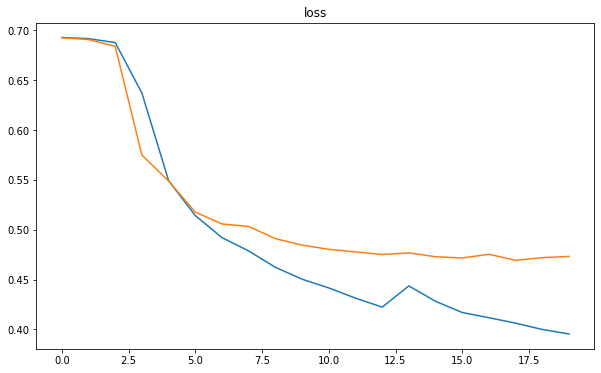

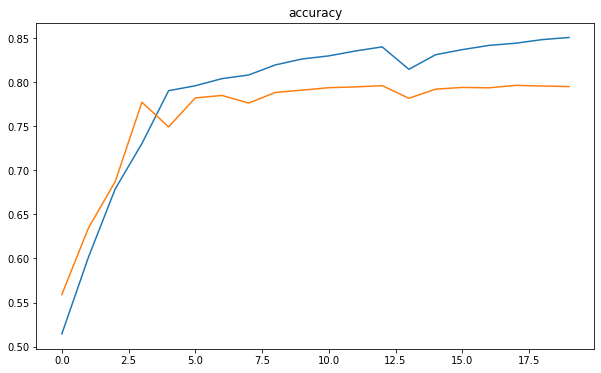

In [22]:
import os
import time

best_model = keras.models.Sequential()
best_model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
best_model.add(keras.layers.Bidirectional(keras.layers.LSTM(8)))
best_model.add(keras.layers.Dense(1, activation="sigmoid"))
best_model.compile(loss="binary_crossentropy", 
                   optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
                             metrics=["accuracy"])

logdir = os.path.join(os.curdir, "my_logs", "run_{}".format(time.time()))
callbacks = [keras.callbacks.TensorBoard(logdir),
             keras.callbacks.EarlyStopping(patience=5),
             keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)]

history_b = best_model.fit(X_train_trim, y_train, callbacks=callbacks,
                    epochs=20, batch_size=128, validation_data=(X_valid_trim, y_valid))

plot_loss(history_b)

plot_accuracy(history_b)

scores = best_model.evaluate(X_test_trim, y_test, verbose=2)

In [15]:
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))

accuracy: 86.80%


The best model I have chosen is the one that shows a smaller difference between accuracied of different sets, in order to choose the one that overfits less. Note it doesn't correspond to the one with the best test evaluation, meaning an improvement of the model is possible.
Also these last representations show the overfitting reduction with respect to the original model. The final results are improved even if still comparable to the first ones.